<a href="https://colab.research.google.com/github/Jay-Wolff/CT-Scan-Project/blob/main/Janissa_Abreu_CTScan_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Identifying the Nodule Locations on CT Scans

In [ ]:
! pip install -q kaggle

In [ ]:
#allows you to connect kaggle account for the data transfer purposes
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#make a directory for kaggle
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
#find where my kaggle json is in my google drive
! cp /content/drive/MyDrive/MidtermProject/kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d 'fanbyprinciple/luna-lung-cancer-dataset'
! unzip -q 1luna-lung-cancer-dataset.zip -d luna16

luna-lung-cancer-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
unzip:  cannot find or open 1luna-lung-cancer-dataset.zip, 1luna-lung-cancer-dataset.zip.zip or 1luna-lung-cancer-dataset.zip.ZIP.


In [ ]:
! pip install SimpleITK

In [ ]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import SimpleITK as sitk

In [ ]:
candidates = pd.read_csv('luna16/candidates_V2/candidates_V2.csv')
annotations = pd.read_csv("luna16/annotations.csv")

In [ ]:
candidates.head()

,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,68.420000,-74.480000,-288.700000,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-95.209361,-91.809406,-377.426350,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-24.766755,-120.379294,-273.361539,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-63.080000,-65.740000,-344.240000,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,52.946688,-92.688873,-241.067872,0


In [ ]:
annotations.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


In [ ]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id='1OFa8UhDvCrcTj1VkFLa7RjifEqMD4TAa'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('subset0.zip')

In [ ]:
! unzip -q subset0.zip

replace subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.raw? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
replace subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
replace subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.raw? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Find a few positive samples

# Extract UIDs from files in subset0 folder
all_mhd = glob.glob('subset0/*.mhd')
name = all_mhd[0]
start_index = name.find('1.')
end_index = name.find('.mhd')
# print(start_index, end_index)
print("ID:", name[start_index:end_index])
ids = [name[start_index:end_index] for name in all_mhd]
print("ID list:", ids)

samples = candidates[(candidates['class'] == 1) &
           (candidates['seriesuid'].isin(ids))].sample(5)
samples

ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354
ID list: ['1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354', '1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912', '1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734', '1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950', '1.3.6.1.4.1.14519.5.2.1.6279.6001.241570579760883349458693655367', '1.3.6.1.4.1.14519.5.2.1.6279.6001.317087518531899043292346860596', '1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227', '1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786169715745131047975', '1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058', '1.3.6.1.4.1.14519.5.2.1.6279.6001.975254950136384517744116790879', '1.3.6.1.4.1.14519.5.2.1.6279.6001.805925269324902055566754756843', '1.3.6.1.4.1.14519.5.2.1.6279.6001.277445975068759205899107114231', '1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768680758082619196', '1.3.6.1.4.1.14519.5.2.1.6279.6001.32

,seriesuid,coordX,coordY,coordZ,class
216137,1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205...,94.506256,-10.193756,-207.250000,1
542537,1.3.6.1.4.1.14519.5.2.1.6279.6001.323859712968...,-80.890166,-74.368400,-115.051331,1
633066,1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256...,-93.910973,63.824128,-98.809998,1
262867,1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116...,-84.956331,-20.507930,-92.000000,1
285808,1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640...,53.089339,137.875900,-627.141098,1


In [ ]:
series_uid = samples['seriesuid'].values[0]
series_uid

'1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748'

In [ ]:
mhd_path = 'subset0/{}.mhd'.format(series_uid)
mhd_path

'subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748.mhd'

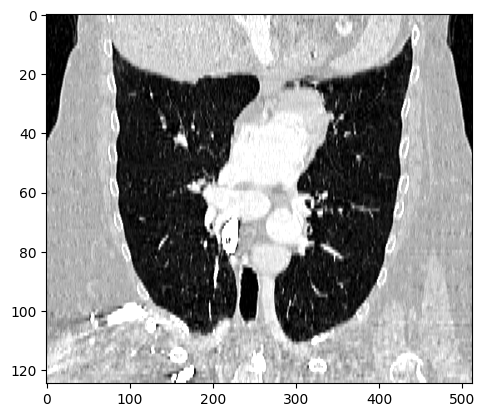

In [ ]:
ct_mhd = sitk.ReadImage(mhd_path)

ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)
ct_a.clip(-1000, 1000, ct_a)
clim = (-1000, 300)

spacingX, spacingY, spacingZ = ct_mhd.GetSpacing()

plt.imshow(ct_a[:, 256, :], clim=clim, cmap='gray', aspect=spacingZ/spacingX)

## Identify a Nodule

In [ ]:
# Create a dataset containing the origin, spacing, and direction information for each CT scan
num_rows = len(ids)
ct_info = pd.DataFrame(0, columns=['originX', 'originY', 'originZ', 'spacingX', 'spacingY', 'spacingZ'], index=ids)
ct_info.head()

,originX,originY,originZ,spacingX,spacingY,spacingZ
1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354,0,0,0,0,0,0
1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912,0,0,0,0,0,0
1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734,0,0,0,0,0,0
1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950,0,0,0,0,0,0
1.3.6.1.4.1.14519.5.2.1.6279.6001.241570579760883349458693655367,0,0,0,0,0,0


In [ ]:
for id in ids:
    mhd_path = 'subset0/{}.mhd'.format(id)
    ct_mhd = sitk.ReadImage(mhd_path)
    ct_info.loc[id, ['originX', 'originY', 'originZ']] = ct_mhd.GetOrigin()
    ct_info.loc[id, ['spacingX', 'spacingY', 'spacingZ']] = ct_mhd.GetSpacing()
    if ct_mhd.GetDirection() != (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0):
        print(id, ct_mhd.GetDirection())
print(ct_info.shape)
ct_info.head()

1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.9999999999999999)
1.3.6.1.4.1.14519.5.2.1.6279.6001.657775098760536289051744981056 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.9999999999999999)
1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557 (0.9999999999999999, 0.0, 0.0, 0.0, 0.9999999999999999, 0.0, 0.0, 0.0, 1.0)
1.3.6.1.4.1.14519.5.2.1.6279.6001.146429221666426688999739595820 (0.9999999999999999, 0.0, 0.0, 0.0, 0.9999999999999999, 0.0, 0.0, 0.0, 1.0)
1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223 (0.9999999999999999, 0.0, 0.0, 0.0, 0.9999999999999999, 0.0, 0.0, 0.0, 1.0)
1.3.6.1.4.1.14519.5.2.1.6279.6001.826812708000318290301835871780 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.9999999999999999)
1.3.6.1.4.1.14519.5.2.1.6279.6001.310626494937915759224334597176 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.9999999999999999)
(89, 6)


,originX,originY,originZ,spacingX,spacingY,spacingZ
1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354,-163.196289,-319.196289,-380.500000,0.607422,0.607422,0.50
1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912,-193.500000,-180.000000,-353.329987,0.703125,0.703125,2.50
1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734,-207.100000,-220.000000,-316.250000,0.859375,0.859375,1.25
1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950,-168.691410,-306.691410,872.000000,0.617188,0.617188,0.70
1.3.6.1.4.1.14519.5.2.1.6279.6001.241570579760883349458693655367,-160.500000,-52.284514,1539.000000,0.611328,0.611328,1.00


In [ ]:
# Define a uniform direction vector for all CT scans
direction_a = np.array([1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]).reshape(3, 3)
print(direction_a)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [ ]:
# Convert the xyz coordinates to (index, row, column)
coordX, coordY, coordZ = samples.loc[samples.index[0], ['coordX', 'coordY', 'coordZ']]
print(coordX, coordY, coordZ)
id = samples.loc[samples.index[0], 'seriesuid']
origin_a = ct_info.loc[id, ['originX', 'originY', 'originZ']].values.reshape([-1])
vxSize_a = ct_info.loc[id, ['spacingX', 'spacingY', 'spacingZ']].values.reshape([-1])
coord_a = np.array([coordX, coordY, coordZ])
cri_a = ((coord_a - origin_a) @ np.linalg.inv(direction_a)) / vxSize_a
cri_a = np.round(cri_a)
index = int(cri_a[2])
row = int(cri_a[1])
col = int(cri_a[0])
index, row, col

94.506256 -10.193756 -207.25


(61, 226, 386)

In [ ]:
mhd_path = 'subset0/{}.mhd'.format(id)
ct_mhd = sitk.ReadImage(mhd_path)
ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)
ct_a.clip(-1000, 1000, ct_a)
ct_chunk = ct_a[(index-16):(index+16), (row-24):(row+24), (col-24):(col+24)]
ct_chunk.shape

(32, 48, 48)

A typical CT-scan is represented by a tensor of size (200, 512, 512). This means that there are a total of 52 million pixels.

We narrow down the range to (32, 48, 48), which only has 73,000 pixels. This basically removes over 99.8% of irrelevant pixels.

In [ ]:
print(200 * 512 * 512)
print(32 * 48 * 48)
print(73728 / 52428800)

52428800
73728
0.00140625


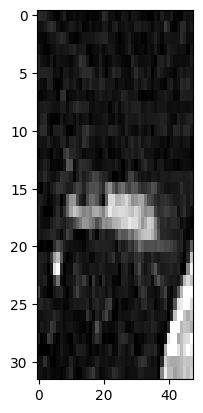

In [ ]:
spacingX, spacingY, spacingZ = ct_mhd.GetSpacing()

plt.imshow(ct_chunk[:, ct_chunk.shape[1]//2, :], clim=clim, cmap='gray', aspect=spacingZ/spacingX)

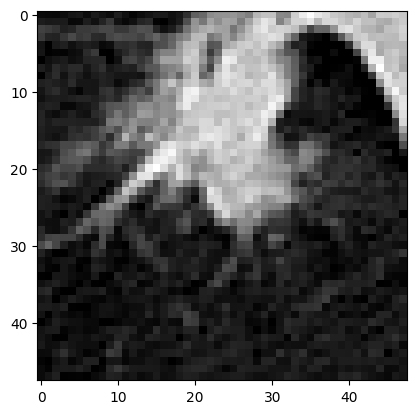

In [ ]:
plt.imshow(ct_chunk[ct_chunk.shape[0]//2, :, :], clim=clim, cmap='gray')

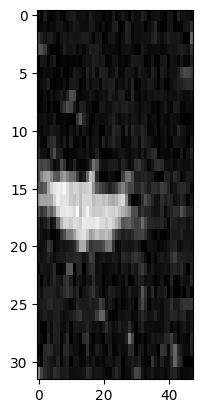

In [ ]:
plt.imshow(ct_chunk[:, :, ct_chunk.shape[2]//2], clim=clim, cmap='gray', aspect=spacingZ/spacingX)

## Calculate the index, row, col for Each Nodule

In [ ]:
for idx in candidates.index:
    coordX, coordY, coordZ = candidates.loc[idx, ['coordX', 'coordY', 'coordZ']]
    id = candidates.loc[idx, 'seriesuid']
    if id not in ct_info.index:
        continue
    origin_a = ct_info.loc[id, ['originX', 'originY', 'originZ']].values.reshape([-1])
    vxSize_a = ct_info.loc[id, ['spacingX', 'spacingY', 'spacingZ']].values.reshape([-1])
    coord_a = np.array([coordX, coordY, coordZ])
    cri_a = ((coord_a - origin_a) @ np.linalg.inv(direction_a)) / vxSize_a
    cri_a = np.round(cri_a)
    candidates.loc[idx, 'index'] = int(cri_a[2])
    candidates.loc[idx, 'row'] = int(cri_a[1])
    candidates.loc[idx, 'col'] = int(cri_a[0])

In [ ]:
candidates.isnull().sum()

seriesuid         0
coordX            0
coordY            0
coordZ            0
class             0
index        675840
row          675840
col          675840
dtype: int64

In [ ]:
candidates_processed = candidates.dropna()
candidates_processed.isnull().sum()

seriesuid    0
coordX       0
coordY       0
coordZ       0
class        0
index        0
row          0
col          0
dtype: int64

In [ ]:
candidates_processed.shape

(79135, 8)

In [ ]:
candidates_processed.dtypes

seriesuid     object
coordX       float64
coordY       float64
coordZ       float64
class          int64
index        float64
row          float64
col          float64
dtype: object

In [ ]:
candidates_processed[['index', 'row', 'col']] = candidates_processed[['index', 'row', 'col']].astype(int)

<ipython-input-52-501ebfcf4df7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates_processed[['index', 'row', 'col']] = candidates_processed[['index', 'row', 'col']].astype(int)


In [ ]:
candidates_processed.to_csv('candidates_processed.csv', index=False)

In [ ]:
temp = pd.read_csv('candidates_processed.csv')
temp.head()

,seriesuid,coordX,coordY,coordZ,class,index,row,col
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,-66.383107,57.143607,-60.885862,0,110,331,173
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,-132.856859,23.813034,-274.350845,0,24,287,86
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,84.770000,66.170000,-249.880000,0,34,343,371
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,134.805360,29.696241,-268.116009,0,27,295,437
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,-87.092676,41.722383,-208.831394,0,51,311,146


In [ ]:
# Save to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls drive/MyDrive

 0-0.gdoc
 1_2_part_1.pdf
'2_1(1).pdf'
 2_2.pdf
 3_1.pdf
 3_2.pdf
'3_3(1).pdf'
'426 Zybook Questions.gdoc'
 610691929-420800411-247f1372-59d5-453a-8ba5-bc2875cce55f.mp4
'8 10 Presentation.gslides'
'8 18 Presentation.gslides'
'Abreu, Janissa_Personal Statement.gdoc'
 accounts.gdoc
'Ace #2.mp4'
'A few poems from a 5ft girl.gdoc'
 AI_Midterm.gdoc
'AI Notes.gdoc'
'All My Sites.gdoc'
 APPEAL.gdoc
'apraxia .gdoc'
'ART 102 Project.gslides'
'A Story With No Title .gdoc'
 AT-cm_l9tcYcBtdiGhzAKSeQZnHg.mp4
 AT-cm_x3QGB3Po62Hzv_WAig35qQ.mp4
 Aura.gdoc
 B74FA262-051B-40CF-AC1E-9B0409F3C53F.JPG
 BackOfInsurance
'Big Blockchain Brain Bussy Buster.gdoc'
'BIO 1-4 SG.gdoc'
'BIO essay.gdoc'
'Broken Links.gdoc'
'Broken Links.gsheet'
'Calc Midterm.gdoc'
"can't break these walls .gdoc"
'CGI 325 Midterm Part 1.gdoc'
 CGI.gdoc
 ch2.gslides
 ch3.gslides
 ch4.gslides
 ch5.gslides
'Chap 1-7 Database.gslides'
'Chapter 13 & 14 study guide .gdoc'
 chat-media-video-CELSIUS2017~8544DD55-96E1-24FE-3384-4B4C1E9F6D36.MO

In [ ]:
candidates_processed.to_csv('drive/MyDrive/candidates_processed.csv', index=False)

In [ ]:
temp = pd.read_csv('drive/MyDrive/candidates_processed.csv')
temp.head()

,seriesuid,coordX,coordY,coordZ,class,index,row,col
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,-66.383107,57.143607,-60.885862,0,110,331,173
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,-132.856859,23.813034,-274.350845,0,24,287,86
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,84.770000,66.170000,-249.880000,0,34,343,371
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,134.805360,29.696241,-268.116009,0,27,295,437
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,-87.092676,41.722383,-208.831394,0,51,311,146


In [ ]:
# Also save the ct_info data frame.

